In [40]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torchvision import datasets, transforms

Files already downloaded and verified
2
torch.Size([16, 3, 32, 32])
torch.Size([16])
tensor(9)


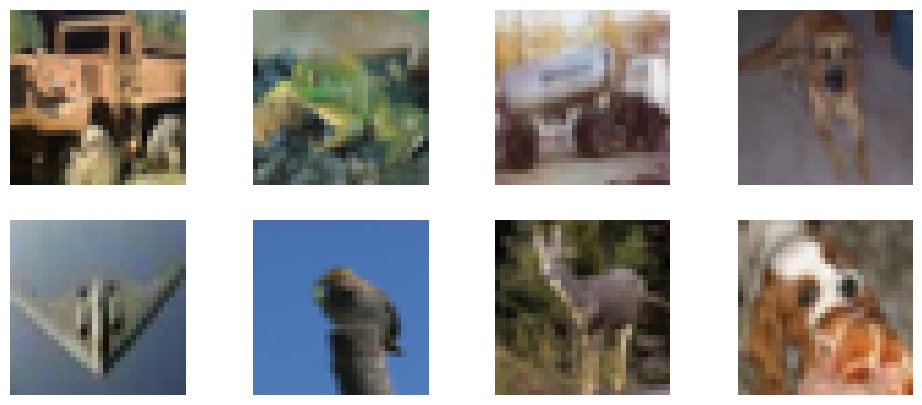

In [6]:
bs = 16

dataloader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data/', train=True, download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                  ])
                 ),
    batch_size=bs, shuffle=True
)

# 시각화
def visualize(img, epoch=0):
    if img.shape[0] == 1:
        plt.figure(figsize=(2,2))
        img = img.squeeze().permute(1,2,0)
        plt.imshow(img)
        plt.show()
    elif img.shape[0]>1 and len(img.shape)>2:
        fig, axes = plt.subplots(2, 4, figsize=(12, 5))
        for i, ax in enumerate(axes.flat):
            ax.imshow(img[i].squeeze().permute(1,2,0))
            ax.axis('off')
        # plt.savefig(f'{output_path}/valid_{epoch}.png')
        plt.show()

# 데이터 체크
data = next(iter(dataloader))
print(len(data))
print(data[0].shape)
print(data[1].shape)
print(data[1][0])

visualize(data[0])

In [7]:
import torch.nn as nn

class Unet(nn.Module):
    def __init__(self):
        super(self, Uner).__init__()

    def forward(self, x):
        return x

In [8]:
initial = torch.randn(28,28)
print(initial.shape)

torch.Size([28, 28])


In [21]:
test_img = data[0][0]
print(test_img.shape)

def Conv(in_channels, out_channels, kernel_size, stride, padding):
    return torch.nn.Conv2d(
        in_channels=in_channels, out_channels=out_channels,
        kernel_size=kernel_size, stride=stride, padding=padding
    )


torch.Size([3, 32, 32])


In [23]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(Block, self).__init__()
        self.conv=nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=kernel_size, stride=stride, padding=padding
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.0)

    def forward(self, x, scale_shift):
        out = self.conv(x)
        out = self.bn(out)

        scale, shift = scale_shift
        out = out*(scale+1)+shift
        
        out = self.relu(out)
        out = self.dropout(out)

        return out

In [ ]:
class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, dim, theta=10000):
        super().__init__()
        self.dim = dim
        self.theta = ehta

    def forward(self, x):
        device=x.device
        half_dim = self.dim // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In [ ]:
class AttnBlock(nn.Module):
    def __init__(self, in_c):
        super(AttnBlock, self).__init__()
        self.query = nn.Conv2d(in_c, in_c, kernel_size=1, stride=1, padding=1)
        self.key = nn.Conv2d(in_c, in_c, kernel_size=1, stride=1, padding=1)
        self.value = nn.Conv2d(in_c, in_c, kernel_size=1, stride=1, padding=1)

    def forward(self, x):
        B, C, H, W = x.shape
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        
        
        return x

In [53]:
import torch.nn as nn

class ResConvblock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, is_attn, time_embed_dim):
        super(ResConvblock, self).__init__()
        self.block1 = Block(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.block2 = Block(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        
        self.is_atten = is_attn

        self.time_mlp = nn.Linear(time_emb_dim, out_channels*2) # 앞에 activation func 한개 있어야 한다 일단 생략
        
        self.residual = nn.Identity()
        if in_channels != out_channels:
            self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, time_emb):
        time_emb = self.time_emb = self.time_mlp(time_emb)
        time_emb = rearrange(time_emb, 'b c -> b c 1 1')
        scale_shift = time_emb.chunk(2, dim=1)
        
        out = self.block1(x, scale_shift)
        
        if self.is_atten:
            out = out
        
        out = self.block2(out, scale_shift)
        return out + self.residual(x)

convblock = ResConvblock(3, 3, False)

In [54]:
feature_map = convblock(test_img.unsqueeze(dim=0))
print(feature_map.shape)

feature_map = convblock(feature_map)
print(feature_map.shape)

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


In [39]:
maxpool = nn.MaxPool2d(2, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
maxpool(feature_map).shape

torch.Size([1, 3, 16, 16])

In [41]:
feature_map.shape

torch.Size([1, 3, 32, 32])

In [42]:
nn.Upsample(scale_factor=2, mode='nearest')(feature_map).shape

torch.Size([1, 3, 64, 64])

In [ ]:
class DownSample(nn.Module):
    """
    초기에는 Maxpooling도 썼지만 conv stride2가 더 정보가 많으니 그걸 쓴다.
    """
    def __init__(self, chn):
        super(DownSample, self).__init__()
        self.down = nn.Conv2d(chn, chn, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        return self.down(x)

class Upsample(nn.Module):
    def __init__(self, chn):
        super(Upsample, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = nn.Conv2d(chn, chn, kernelsize=3, stride=1, padding=1)

    def forward(self, x):
        x = self.up(x)
        x = self.conv(x)
        return x

In [6]:
class Unet(nn.Module):
    def __init__(
        self,
        dim=64,
        mults=[1,2,4,8]
    ):
        super(Unet, self).__init__()
        
        self.init_conv = nn.Conv2d(3, dim, kernel_size=3, stride=1, padding=1)
        
        time_dim = dim*4
        sinu_pos_embedding = SinusoidalPositionalEmbedding(dim, 10000)
        self.time_mlp = nn.Sequential(
            sinu_pos_embedding,
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        in_channels=dim
        self.downblocks = nn.ModuleList()
        for mult in mults:
            out_channels = dim*mult
            self.downblocks.append(
                ResConvblock(in_channels, out_channels, is_atten=False, time_dim)
            )
            in_channels = dim*mult
            self.downblocks.append(
                Down
            )
        
        middle_channel = dim * mults[-1]
        self.middle_layers = nn.ModuleList([
            ResConvblock(middle_channel, middle_channel, is_attn=False, time_dim),
            ResConvblock(middle_channel, middle_channel, is_attn=False, time_dim)
        ])

    def forward(self, x, t):
        initial = self.init_conv(x)
        t_emb = self.time_mlp(t) # 같은 t_emb가 각 ResNet Block에 들어간다.

        for layer in self.middle_layers:
            x = layer(x, t_emb)
        
        return x

SyntaxError: positional argument follows keyword argument (3725100379.py, line 25)

In [48]:
unet = Unet()

TypeError: super(type, obj): obj must be an instance or subtype of type

In [3]:
import torch

test = torch.ones(32, 64, 1, 1)
print(test.shape)
test = test.chunk(2, dim=1)
print(test[0].shape)

torch.Size([32, 64, 1, 1])
torch.Size([32, 32, 1, 1])


In [4]:
t=0.

In [5]:
t

0.0